In [ ]:
import cv2, os
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from keras.models import Sequential
#from keras.optimizers import Adam
#from keras.callbacks import ModelCheckpoint
#from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import torch
import torch.nn
from torch.optim import Adam
#from utilis import INPUT_SHAPE, batch_generator
import argparse
import os



IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)


def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """

    return mpimg.imread(image_file)


def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :] # remove the sky and the car front


def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


# def rgb2yuv(image):
#     """
#     Convert the image from RGB to YUV (This is what the NVIDIA model does)
#     """
#     rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
#     return cv2.cvtColor(rgb, cv2.COLOR_BGR2YUV )


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    # image = rgb2yuv(image)
    image_shape = image.shape
    # image = image.reshape(image_shape[0],image_shape[1],1)
    # image = cv2.imread(image,0)
    # image = image.reshape(image_shape[0],image_shape[1],1)
    
    img = np.mean(image, axis=2)
    # print("The shape of the the image is" + str(img.shape))
    return img.reshape(image_shape[0],image_shape[1],1)


def choose_image(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle


def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle


def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


# def random_shadow(image):
#     """
#     Generates and adds random shadow
#     """
#     # (x1, y1) and (x2, y2) forms a line
#     # xm, ym gives all the locations of the image
#     x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
#     x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
#     xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]
#
#     # mathematically speaking, we want to set 1 below the line and zero otherwise
#     # Our coordinate is up side down.  So, the above the line:
#     # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
#     # as x2 == x1 causes zero-division problem, we'll write it in the below form:
#     # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
#     mask = np.zeros_like(image[:, :, 1])
#     mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1
#
#     # choose which side should have shadow and adjust saturation
#     cond = mask == np.random.randint(2)
#     s_ratio = np.random.uniform(low=0.2, high=0.5)
#
#     # adjust Saturation in HLS(Hue, Light, Saturation)
#     hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#     hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
#     return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


# def random_brightness(image):
#     """
#     Randomly adjust brightness of the image.
#     """
#     # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
#     rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
#     hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
#     ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
#     hsv[:,:,2] =  hsv[:,:,2] * ratio
#     return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    #image = random_shadow(image)
    # image = random_brightness(image)
    return image, steering_angle


def batch_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 1])
    steers = np.empty(batch_size)
    # while True:
    i = 0
    for index in np.random.permutation(image_paths.shape[0]):
        center, left, right = image_paths[index]
        steering_angle = steering_angles[index]
        # argumentation
        if is_training and np.random.rand() < 0.6:
            image, steering_angle = augument(data_dir, center, left, right, steering_angle)
        else:
            image = load_image(data_dir, center)
        # add the image and steering angle to the batch
        images[i % batch_size] = preprocess(image)
        steers[i % batch_size] = steering_angle
        i += 1
        if i % batch_size == 0:
            yield images, steers
            images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 1])
            steers = np.empty(batch_size)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/drive/MyDrive/data/data.rar').extractall('/content/IMG')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x = pd.read_csv('/content/data.csv')
x.head()

,Unnamed: 0,center,left,right,steering,speed,throttle,break
0,0,/content/IMG/center_2021_05_15_04_32_09_587.jpg,/content/IMG/left_2021_05_15_04_32_09_587.jpg,/content/IMG/right_2021_05_15_04_32_09_587.jpg,0.0,1,0,4.253256
1,1,/content/IMG/center_2021_05_15_04_32_09_652.jpg,/content/IMG/left_2021_05_15_04_32_09_652.jpg,/content/IMG/right_2021_05_15_04_32_09_652.jpg,0.0,1,0,4.951154
2,2,/content/IMG/center_2021_05_15_04_32_09_719.jpg,/content/IMG/left_2021_05_15_04_32_09_719.jpg,/content/IMG/right_2021_05_15_04_32_09_719.jpg,0.0,1,0,5.878301
3,3,/content/IMG/center_2021_05_15_04_32_09_802.jpg,/content/IMG/left_2021_05_15_04_32_09_802.jpg,/content/IMG/right_2021_05_15_04_32_09_802.jpg,0.0,1,0,6.798285
4,4,/content/IMG/center_2021_05_15_04_32_09_875.jpg,/content/IMG/left_2021_05_15_04_32_09_875.jpg,/content/IMG/right_2021_05_15_04_32_09_875.jpg,0.0,1,0,7.483586


In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5304 entries, 0 to 5303
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5304 non-null   int64  
 1   center      5304 non-null   object 
 2   left        5304 non-null   object 
 3   right       5304 non-null   object 
 4   steering    5304 non-null   float64
 5   speed       5304 non-null   int64  
 6   throttle    5304 non-null   int64  
 7   break       5304 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 331.6+ KB


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/content/IMG/center_2021_05_15_04_32_49_137.jpg


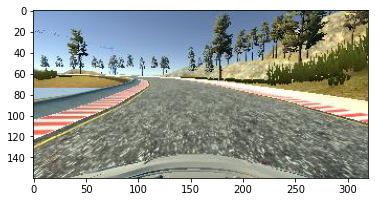

In [ ]:
path = x['center'][533]
print(path)
image = mpimg.imread(path)
plt.imshow(image)
plt.show()

In [ ]:
np.random.seed(0)
training_loss = []
validation_loss = []

def load_data(args):
    """
    Load training data and split it into training and validation set
    """
    #print(os.path.join(args.data_dir,'driving_log.csv'))
    data_df = pd.read_csv('/content/data.csv')

    X = data_df[['center','left','right']].values
    y = data_df['steering'].values
    # X = X[:2000]
    # y = y[:2000]
    print(X.shape)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=args.test_size, random_state=0)
    #X_train = X_train / 127.5 - 1.0
    #X_valid = X_valid / 127.5 - 1.0
    return X_train, X_valid, y_train, y_valid


def build_model(args):
    """
    Modified NVIDIA model
    """
    model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 1, out_channels = 24,kernel_size = (5,5), stride = (2,2)),
        torch.nn.ELU(),
        torch.nn.Conv2d(in_channels=24, out_channels=36, kernel_size=(5, 5), stride=(2, 2)),
        torch.nn.ELU(),
        torch.nn.Conv2d(in_channels=36, out_channels=48, kernel_size=(5, 5), stride=(2, 2)),
        torch.nn.ELU(),
        torch.nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3,3), stride=(1, 1)),
        torch.nn.ELU(),
        torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1, 1)),
        torch.nn.ELU(),
        torch.nn.Dropout(p=args.keep_prob, inplace=True),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features = 1152, out_features = 100,bias = True),
        torch.nn.ELU(),
        torch.nn.Linear(in_features = 100,out_features = 50,bias = True),
        torch.nn.ELU(),
        torch.nn.Linear(in_features = 50,out_features = 10,bias = True),
        torch.nn.ELU(),
        torch.nn.Linear(in_features = 10,out_features = 1,bias = True)
    )
    #model = Sequential()
    #model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=INPUT_SHAPE))
    #model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    #model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    #model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    #model.add(Conv2D(64, 3, 3, activation='elu'))
    #model.add(Conv2D(64, 3, 3, activation='elu'))
    #model.add(Dropout(args.keep_prob))
    #model.add(Flatten())
    #model.add(Dense(100, activation='elu'))
    #model.add(Dense(50, activation='elu'))
    #model.add(Dense(10, activation='elu'))
    #model.add(Dense(1))
    #model.summary()

    return model


def train_model(model, args, X_train, X_valid, y_train, y_valid):
    """
    Train the model
    """
    criterion = torch.nn.MSELoss()

    optimizer = Adam(model.parameters(),lr = args.learning_rate)

    
    for epoch in range(args.nb_epoch):
        running_loss = 0
        total_loss_valid = 0
        model.train()
        total_loss = 0
        i = 0
        print('Epoch : {}'.format(epoch + 1))
        print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
        for imgs,steers in batch_generator(args.data_dir, X_train, y_train, args.batch_size, True):

            shape_imgs = imgs.shape
            imgs = imgs.reshape(shape_imgs[0],1,shape_imgs[1],shape_imgs[2])
            imgs = torch.FloatTensor(imgs)
            steers = steers.reshape(args.batch_size,1)
            steers = torch.FloatTensor(steers)
            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, steers)


            loss.backward()
            optimizer.step()
            i = i + 1
            running_loss += loss.item()
            del loss

            # print statistics
            if i % 5 == 0:  # print every 5 mini-batches
                print('The training loss: %.6f after %d' % (running_loss / (i),i))

        running_loss = running_loss / (X_train.shape[0]  / 40)



        model.eval()


        j = 0
        for imgs, steers in batch_generator(args.data_dir, X_valid, y_valid, args.batch_size, False):

            shape_imgs = imgs.shape
            imgs = imgs.reshape(shape_imgs[0], 1, shape_imgs[1], shape_imgs[2])
            imgs  = torch.FloatTensor(imgs)
            steers = steers.reshape(args.batch_size, 1)
            steers = torch.FloatTensor(steers)
            optimizer.zero_grad()

            j = j + 1
            outputs = model(imgs)
            loss = criterion(outputs, steers)
            total_loss_valid = total_loss_valid + loss.item()
            if j % 5 == 0:  # print every 5 mini-batches
                print('The Validation loss: %.6f after %d' % (total_loss_valid / (j), j))

        total_loss_valid = total_loss_valid / (X_valid.shape[0] / 40)

        training_loss.append(running_loss)

        print('The training loss after epoch{} is {}'.format(epoch,(running_loss)))
        validation_loss.append(total_loss_valid)
        print('The validation loss after epoch{} is {}'.format(epoch, total_loss_valid))



def s2b(s):
    """
    Converts a string to boolean value
    """
    s = s.lower()
    return s == 'true' or s == 'yes' or s == 'y' or s == '1'


def main():
    """
    Load train/validation data set and train the model
    """
    parser = argparse.ArgumentParser(description='Behavioral Cloning Training Program')
    parser.add_argument('-d', help='data directory', dest='data_dir', type=str, default='/content/')
    parser.add_argument('-t', help='test size fraction', dest='test_size', type=float, default=0.2)
    parser.add_argument('-k', help='drop out probability', dest='keep_prob', type=float, default=0.5)
    parser.add_argument('-n', help='number of epochs', dest='nb_epoch', type=int, default=30)
    parser.add_argument('-s', help='samples per epoch', dest='samples_per_epoch', type=int, default=20000)
    parser.add_argument('-b', help='batch size', dest='batch_size', type=int, default=40)
    parser.add_argument('-o', help='save best models only', dest='save_best_only', type=s2b, default='true')
    parser.add_argument('-l', help='learning rate', dest='learning_rate', type=float, default=1.0e-4)
    args = parser.parse_args(args = [])

    print('-' * 30)
    print('Parameters')
    print('-' * 30)
    for key, value in vars(args).items():
        print('{:<20} := {}'.format(key, value))
    print('-' * 30)

    data = load_data(args)
    model = build_model(args)
    train_model(model, args, *data)



    torch.save(model, 'model.pt')
if __name__ == '__main__':
    main()

------------------------------
Parameters
------------------------------
data_dir             := /content/
test_size            := 0.2
keep_prob            := 0.5
nb_epoch             := 30
samples_per_epoch    := 20000
batch_size           := 40
save_best_only       := True
learning_rate        := 0.0001
------------------------------
(5304, 3)
Epoch : 1
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
The training loss: 0.047158 after 5
The training loss: 0.041672 after 10
The training loss: 0.043886 after 15
The training loss: 0.041677 after 20
The training loss: 0.041812 after 25
The training loss: 0.043072 after 30
The training loss: 0.041147 after 35
The training loss: 0.040465 after 40
The training loss: 0.041058 after 45
The training loss: 0.039724 after 50
The training loss: 0.039580 after 55
The training loss: 0.039106 after 60
The training loss: 0.038632 after 65
The training loss: 0.038204 after 70
The training loss: 0.037579 after 75
The t

In [ ]:
min_value = min(training_loss)
min_index = training_loss.index(min_value)
print(min_value)
print(min_index)
print(len(training_loss))

NameError: ignored

In [ ]:
min_value = min(validation_loss)
min_index = validation_loss.index(min_value)
print(min_value)
print(min_index)
print(len(validation_loss))

0.011725464061562685
48
50


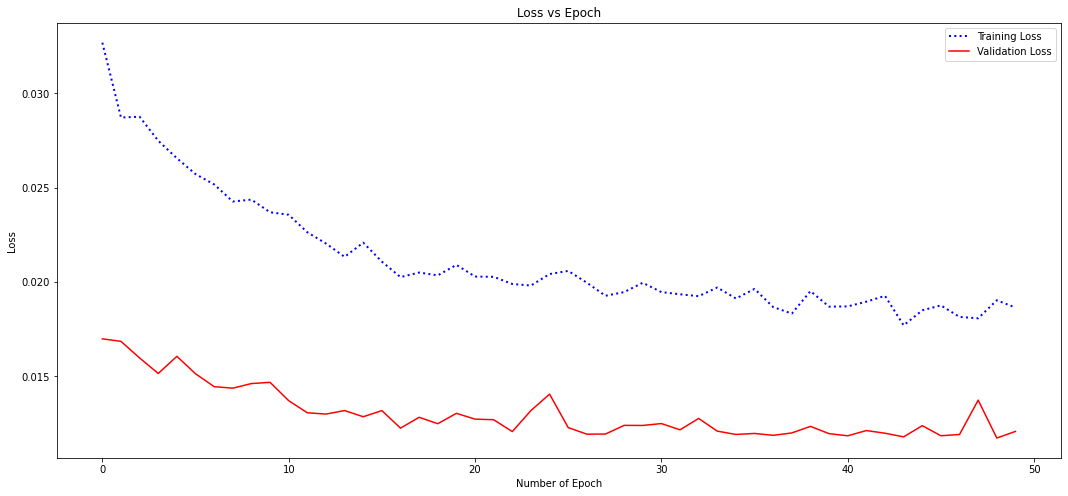

In [ ]:
plt.figure(figsize = (18,8))
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(False)
plt.title("Loss vs Epoch")
plt.xlabel("Number of Epoch")
plt.ylabel("Loss")
labels = ['Training Loss', 'Validation Loss']
plt.plot(training_loss, 'b:', label= labels[0], linewidth=2)
plt.plot(validation_loss,'r', label=labels[1])
plt.legend()
plt.show()

Converting Images to Grayscale For Training the Model.

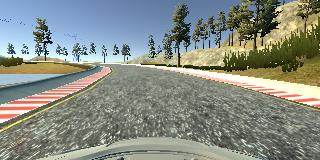

(160, 320, 3)


In [ ]:
from google.colab.patches import cv2_imshow

path = x['center'][533]
RGB = cv2.imread(path,1)
gray = cv2.imread(path,0)
# Showing grayscale image

cv2_imshow(RGB)
# waiting for key event
cv2.waitKey(0)

# destroying all windows
cv2.destroyAllWindows()
print(RGB.shape)


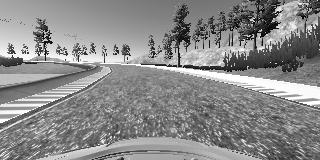

(160, 320)
(160, 320, 1)


In [ ]:
cv2_imshow(gray)
print(gray.shape)
shape = gray.shape
gray = gray.reshape(shape[0],shape[1],1)
print(gray.shape)

In [ ]:
for i in range(x.shape[0]):
  path_center = x['center'][i]
  path_left = x['left'][i]
  path_right = x['right'][i]

  gray_center = cv2.imread(path_center,0)
  gray_left = cv2.imread(path_left,0)
  gray_right = cv2.imread(path_right,0)

  cv2.imwrite(path_center,gray_center)
  cv2.imwrite(path_left,gray_left)
  cv2.imwrite(path_right,gray_right)

All the images are now grayscale but we need to reshape the images.

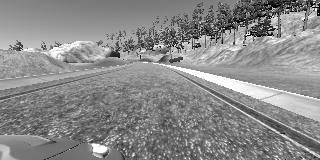

(160, 320)
(160, 320, 1)


In [ ]:
path = x['right'][2522]
img = cv2.imread(path,-1)
cv2_imshow(img)
print(img.shape)
shape = img.shape
img = img.reshape(shape[0],shape[1],1)
print(img.shape)